In [1]:
import sys
sys.path.append("D:/Notebooks/modules")
from utils import scantree
from utils_3d import show_slices_gif_tensor, show_slices_gif_paths, rotate_3d_tensor, plot_3d_volume_mayavi, TensorPathsDataset, get_front_views
from transforms import Rotate3d
from CTKidney_models import VCNNI, VCNNII, MVCNN

import random
import torch
from torch import nn
import os
from collections import defaultdict
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


d:\ProgramFiles\anaconda3\envs\pytorch_env\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
d:\ProgramFiles\anaconda3\envs\pytorch_env\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [2]:
config = {
    'input_shape': (30, 128, 128),
    'batch_size': 64,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'n_epochs': 200,
    'seed': 0,
    'get_front_view_thresh': 0.15
}

152 21
torch.Size([64, 30, 128, 128]) torch.Size([64])
tensor(0.) tensor(1.) tensor([2, 0, 3, 0, 1, 2, 0, 2, 0, 2, 0, 1, 1, 0, 0, 0, 2, 0, 2, 0, 1, 1, 2, 1,
        2, 2, 1, 0, 3, 3, 2, 0, 2, 2, 0, 1, 0, 0, 2, 2, 0, 2, 1, 1, 2, 0, 1, 1,
        0, 0, 2, 3, 0, 1, 2, 3, 2, 2, 3, 2, 1, 0, 1, 2])


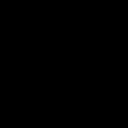

In [3]:
train_dataset = TensorPathsDataset(r'D:\Notebooks\Kidney CT\augmented_volumes\Rotate3d_AllAxes_-30to30_RandomFlip3d\Train', 20, 'train')
valid_dataset = TensorPathsDataset(r'D:\Notebooks\Kidney CT\augmented_volumes\Rotate3d_AllAxes_-30to30_RandomFlip3d\Valid', 20, 'valid')

print(len(train_dataset), len(valid_dataset))

train_loader = DataLoader(train_dataset, batch_size = config['batch_size'], shuffle= True)
valid_loader = DataLoader(valid_dataset, batch_size = config['batch_size'])

volumes, labels = next(iter(train_loader))
print(volumes.shape, labels.shape)
print(volumes.min(), volumes.max(), labels)

show_slices_gif_tensor(volumes[0])
# plot_3d_volume_mayavi(volumes[0])

In [4]:
class FusionNet(nn.Module):
    def __init__(self, vcnn1_path, vcnn2_path, mvcnn_path, weights = [0.05, 0.05, 0.9]):
        super(FusionNet, self).__init__()

        self.vcnn1 = VCNNI(config['input_shape'])
        self.vcnn1.load_state_dict(torch.load(vcnn1_path))

        self.vcnn2 = VCNNII(config['input_shape'])
        self.vcnn2.load_state_dict(torch.load(vcnn2_path))

        self.mvcnn = MVCNN()
        self.mvcnn.load_state_dict(torch.load(mvcnn_path))

        self.weights = weights

    def forward_multi_view(self, volumes, images):
        logits = []
        vcnn1_logits = self.vcnn1.forward_multi_view(volumes)
        vcnn2_logits = self.vcnn2.forward_multi_view(volumes)
        mvcnn_logits = self.mvcnn.forward_multi_view(images)

        return torch.cat([vcnn1_logits * self.weights[0], vcnn2_logits * self.weights[1], mvcnn_logits * self.weights[2]], dim = 0).sum(dim = 0)


In [5]:
model = FusionNet("V-CNN I.pt", "V-CNN II.pt", "MV-CNN.pt").to(config['device'])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6520\1553252374.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.vcnn1.load_state_dict(torch.load(vcnn1_path))
C:\Users\AS

In [6]:
batch, labels = next(iter(valid_loader))
print(batch.shape, labels.shape)

volumes = batch[0]
images = get_front_views(volumes, config['get_front_view_thresh'])
print(volumes.shape, images.shape)

torch.Size([21, 20, 30, 128, 128]) torch.Size([21])
torch.Size([20, 30, 128, 128]) torch.Size([20, 3, 128, 128])


In [7]:
loss_fn = nn.CrossEntropyLoss()

def get_accuracy(logits, targets):
    preds = torch.argmax(logits, dim = 1)
    return torch.sum(preds == targets).item() / len(preds)

In [8]:
model.eval()

valid_loss = 0
valid_acc  = 0

with torch.inference_mode():
    for batch, labels in valid_loader:
        labels = labels.to(config['device'])
        logits_list = []

        for volumes in batch:
            images = get_front_views(volumes, config['get_front_view_thresh'])
            volumes, images = volumes.to(config['device']), images.to(config['device'])
            
            logits = model.forward_multi_view(volumes, images)
            logits_list.append(logits.squeeze())

        logits_list = torch.stack(logits_list)
        loss = loss_fn(logits_list, labels)
        valid_loss += loss.detach().cpu().item()
        valid_acc += get_accuracy(logits_list, labels)

valid_loss /= len(valid_loader)
valid_acc /= len(valid_loader)

print(f"Validation loss: {valid_loss:.4f}    Validation accuracy: {valid_acc:.4f}", )

Validation loss: 0.9533    Validation accuracy: 0.7619
